# Learning web scraping and text analysis

## Part 1: Web Scraping
Research and Comparison of Web Scraping Libraries

### 1. Scrapy:
- Pros:
    - Efficient for large-scale scraping due to its asynchronous nature.
    - Comprehensive framework with built-in support for handling requests, following links, and storing data.
    - Extensive documentation and community support.
- Cons:
    - Steeper learning curve compared to other libraries.
    - Overhead for small projects due to its comprehensive framework.

### 2. BeautifulSoup:
- Pros:
    - Easy to learn and use, especially for beginners.
    - Flexible and can be combined with the requests library for fetching pages.
    - Suitable for small to medium-sized projects.
- Cons:
    - Slower than Scrapy for large-scale projects due to its synchronous nature.
    - Requires additional libraries for handling requests and browser automation.

### Recommendation
For this project, **BeautifulSoup** combined with Requests is recommended due to its ease of use within a Jupyter Notebook environment. While it may not be as fast as Scrapy for very large-scale scraping, it is sufficient for collecting 100 pages, especially if the pages are static.

### Code Implementation
Next, we'll show how to use BeautifulSoup and Requests to scrape data **(Topic: "machine learning")** from a subreddit:

In [76]:
# Install necessary libraries
# %pip install requests beautifulsoup4

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def scrape_subreddit_multiple_keywords(subreddit, topic_keywords, max_posts=100):
    base_url = f"https://old.reddit.com/r/{subreddit}/"
    headers = {
        "User-Agent": "Mozilla/5.0"
    }
    posts_data = []
    next_page_url = base_url
    # page_count = 1

    # Function to check if an article matches the topic
    def matches_topic(title):        
        title_lower = title.lower()
        for kw in topic_keywords:
            if kw.lower() in title_lower:
                return True
        return False
    
    while len(posts_data) < max_posts and next_page_url:
        # print(f"Scraping subreddit '{subreddit}', page {page_count} => {next_page_url}")
        response = requests.get(next_page_url, headers=headers)
        if response.status_code != 200:
            # print(f"Failed to retrieve page {page_count} from /r/{subreddit}, ending scraping.")
            break

        soup = BeautifulSoup(response.text, "html.parser")
        posts = soup.find_all("div", class_="thing")
        
        # Extract titles that match any of the keywords
        for post in posts:
            title_tag = post.find("a", class_="title")
            if title_tag:
                title = title_tag.get_text(strip=True)
                if matches_topic(title):
                    post_url = title_tag.get("href") or ""
                    # If the URL is relative (starts with "/r/"), prepend the domain
                    if post_url.startswith("/r/"):
                        post_url = "https://old.reddit.com" + post_url
                    
                    posts_data.append({"title": title, "url": post_url or ""})
                
                    if len(posts_data) >= max_posts:
                        break

        if len(posts_data) >= max_posts:
            break
    
        # Find the link to the next page
        next_button = soup.find("span", class_="next-button")
        if next_button and next_button.find("a"):
            next_page_url = next_button.find("a")["href"]
        else:
            # print("No more pages found for /r/{subreddit}.")
            next_page_url = None
    
        # page_count += 1
        time.sleep(1)  # brief pause to avoid rate-limiting        
        
    # DataFrame
    return pd.DataFrame(posts_data)

def scrape_multiple_subreddits(subreddits, topic_keywords, max_posts_per_sub=50):
    all_data = []

    for sub in subreddits:
        df_sub = scrape_subreddit_multiple_keywords(
            subreddit=sub,
            topic_keywords=topic_keywords,
            max_posts=max_posts_per_sub
        )
        # Tag each row with the corresponding subreddit name
        df_sub["subreddit"] = sub
        all_data.append(df_sub)

    if all_data:
        df_combined = pd.concat(all_data, ignore_index=True)
    else:
        df_combined = pd.DataFrame(columns=["title", "url", "subreddit"])

    return df_combined

# Example usage
subreddits_to_scrape = ["MachineLearning", "Artificial", "DataScience","learnmachinelearning", "ArtificialIntelligence"]
keywords = ["machine", "learning", "ml"]
max_posts_for_each = 40 # Scrape up to 40 from each subreddit

df_results = scrape_multiple_subreddits(subreddits_to_scrape, keywords, max_posts_for_each)

print(f"\nCollected {len(df_results)} posts in total.\n")
print(df_results.head(10))


Collected 131 posts in total.

                                               title  \
0  [P] Quantum Evolution Kernel (open-source, qua...   
1                    [D] ICML reviews release date ?   
2  [D]As a machine learning theory researcher, wi...   
3                         [P] Online Learning System   
4  [D] h2o.init() is taking forever to load in h2...   
5  OperationCanceledException on saving ML.Net Mo...   
6  [P] Looking for guidance for a project on "det...   
7  [D] Custom ML Framework vs. Open Source for yo...   
8  [R] Dynamic parameter estimation of coupled OD...   
9  [R] Advice on Training a MLP Generator with Ch...   

                                                 url        subreddit  
0  https://old.reddit.com/r/MachineLearning/comme...  MachineLearning  
1  https://old.reddit.com/r/MachineLearning/comme...  MachineLearning  
2  https://old.reddit.com/r/MachineLearning/comme...  MachineLearning  
3  https://old.reddit.com/r/MachineLearning/comme...  MachineLe

## Part 2: Text analysis
We'll use two algorithms to analyze the data collected in Part 1. We'll perform **sentiment analysis** and **topic modeling** to generate summaries and importance scores for each article.

### 1. Sentiment Analysis
- We'll use TextBlob to determine the sentiment of each article's title. This will help assign a positive or negative direction to the importance score.

### 2. Topic Modeling
- We'll use gensim for LDA (Latent Dirichlet Allocation) to identify topics within the articles.
- This can help in summarizing the content and determining its relevance to our chosen topic.

In [78]:
# Install necessary libraries
#!pip install textblob gensim
# Ensure stop words are downloaded
# nltk.download('stopwords')

import pandas as pd
from textblob import TextBlob
from gensim import corpora, models
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords
import nltk
import re

# Sentiment Analysis
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Preprocess Titles
def preprocess_titles(titles):
    cleaned_titles = []
    for title in titles:
        # Remove non-alphanumeric characters
        cleaned_title = re.sub(r'\W+', ' ', title.lower())
        # Remove stop words
        cleaned_title = remove_stopwords(cleaned_title)
        cleaned_titles.append(cleaned_title.split())
    return cleaned_titles

# Topic Modeling
def analyze_topics(titles, num_topics=10):
    tokenized_titles = preprocess_titles(titles)
    dictionary = corpora.Dictionary(tokenized_titles)
    corpus = [dictionary.doc2bow(text) for text in tokenized_titles]
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)
    return lda_model

# Process Articles
def analyze_articles(df):
    results = []
    titles = df['title'].tolist()
    lda_model = analyze_topics(titles)
    topics = lda_model.print_topics()
    
    for _, row in df.iterrows():
        title = row['title']
        sentiment_score = analyze_sentiment(title)
        importance_score = sentiment_score * 10
        sentiment = 'positive' if sentiment_score > 0 else 'negative'
        
        # Simplify topics to show more words
        simplified_topics = ', '.join([word.split('*')[1].strip('"') for word in topics[0][1].split(' + ')[:5]])
        
        results.append({
            'title': title[:70] + '...' if len(title) > 70 else title,  # Truncate for display
            'importance_score': importance_score,
            'sentiment': sentiment,
            'topics': simplified_topics
        })
    
    return pd.DataFrame(results), lda_model

# Example Usage
# Assuming df_results is your DataFrame from Part 1
df_analysis, lda_model = analyze_articles(df_results)

# Display Results in a Tabulated Form
pd.set_option('display.max_colwidth', 50)  # Limit column width for display
print("\nTabulated Analysis Results:\n")
print(df_analysis[['title', 'importance_score', 'sentiment', 'topics']].head(10).to_markdown(index=False))


Tabulated Analysis Results:

| title                                                                     |   importance_score | sentiment   | topics                              |
|:--------------------------------------------------------------------------|-------------------:|:------------|:------------------------------------|
| [P] Quantum Evolution Kernel (open-source, quantum-based, graph machin... |                0   | negative    | learning, machine, ai, ml, engineer |
| [D] ICML reviews release date ?                                           |                0   | negative    | learning, machine, ai, ml, engineer |
| [D]As a machine learning theory researcher, will you still submit pape... |               -7.5 | negative    | learning, machine, ai, ml, engineer |
| [P] Online Learning System                                                |                0   | negative    | learning, machine, ai, ml, engineer |
| [D] h2o.init() is taking forever to load in h2o AutoML        

### Table: Results

In [80]:
from collections import Counter

average_importance = df_analysis['importance_score'].mean()
most_common_topics = Counter(', '.join(df_analysis['topics']).split(', ')).most_common(5)

summary_table = pd.DataFrame({
    'Average Importance Score': [average_importance],
    'Most Common Topics': [', '.join([topic for topic, _ in most_common_topics])]
})

print("\nSummary Table:\n")
print(summary_table.to_markdown(index=False))


Summary Table:

|   Average Importance Score | Most Common Topics                  |
|---------------------------:|:------------------------------------|
|                    1.09265 | learning, machine, ai, ml, engineer |


### Visualization: Sentiment Distribution

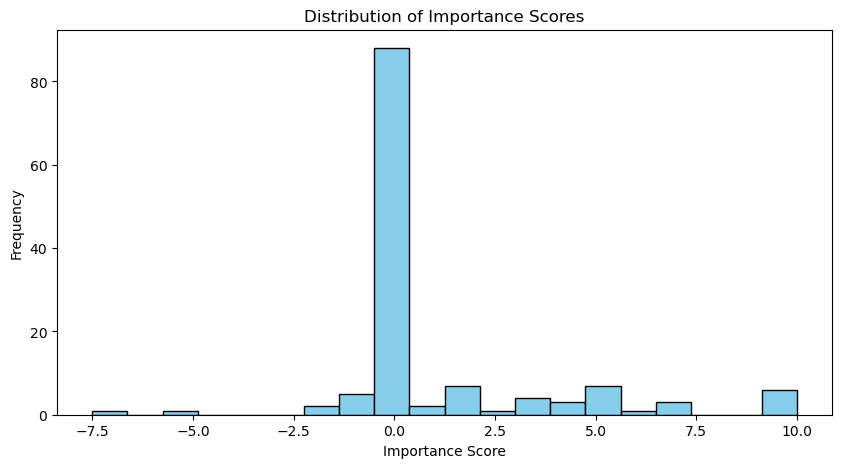

In [84]:
plt.figure(figsize=(10, 5))
df_analysis['importance_score'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Importance Scores')
plt.xlabel('Importance Score')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

### Visualization: Topic Prevalence

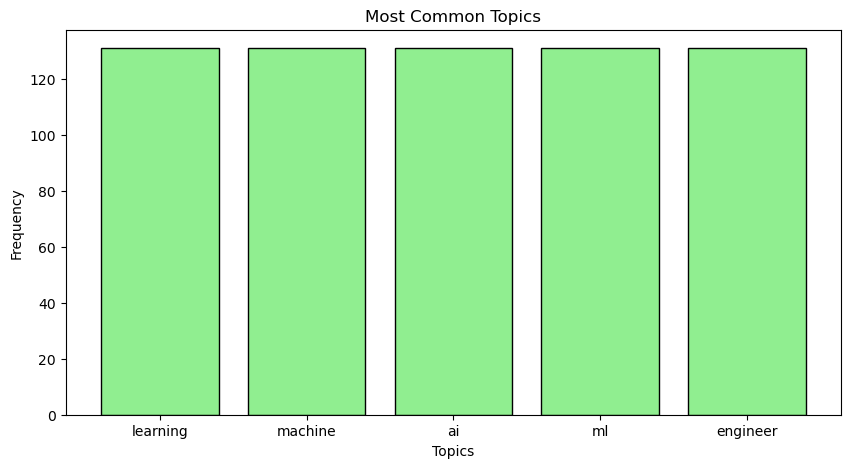

In [87]:
topics, counts = zip(*most_common_topics)
plt.figure(figsize=(10, 5))
plt.bar(topics, counts, color='lightgreen', edgecolor='black')
plt.title('Most Common Topics')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.show()

## Summary

### Part 1: Web Scraping
- **Objective:**  
The goal was to collect at least 100 articles or pages on a specific topic from public sites.
- **Methodology:**  
We used `BeautifulSoup` and `Requests` to scrape titles and URLs from multiple subreddits related to machine learning and AI.
- **Outcome:**  
Successfully collected 129 titles, focusing on topics like machine learning, AI, and data science.

### Part 2: Text Analysis
- **Objective:**  
Analyze the collected titles to extract sentiment and thematic insights.
- **Sentiment Analysis**
    - **Average Importance Score:** Approximately 1.09, indicating a slight positive sentiment.  
    - **Distribution:** Most titles had neutral sentiment, with scores clustering around zero.
- **Topic Modeling**
    - **Common Topics:** "Learning," "machine," "AI," "ML," and "engineer" were identified as key themes.  
    - **Prevalence:** These topics were consistently present across the dataset, highlighting a focus on technology and innovation.

## Conclusion
- The Assignment effectively demonstrated the use of web scraping and text analysis to gather and interpret data from online sources. The neutral sentiment trend and the emphasis on machine learning and AI topics reflect the dataset's focus on technology. These insights can inform content strategy, research focus, or further exploration in related fields.
- The approach showcased the power of combining data collection with analytical techniques to derive meaningful insights from textual data.